# Code for model estimation

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

In [3]:
l = 2
set_id = 3
fold_n = 0
#                         /models/darts_retrained/7ch_128x128_no_metainfo_registered_5Fold_newC43_27Nov2020-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet8_ManCorected_registered_350epochs'
validation_file_path="/mnt/models/darts_retrained/7ch_128x128_no_metainfo_registered_5Fold_newC43_27Nov2020-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation7ch_logits_predictions.csv".format(l, set_id, fold_n)
train_file_path=     "/mnt/models/darts_retrained/7ch_128x128_no_metainfo_registered_5Fold_newC43_27Nov2020-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train7ch_logits_predictions.csv".format(l, set_id, fold_n)

df_val = pd.read_csv(validation_file_path, index_col=0)
df_train = pd.read_csv(train_file_path, index_col=0)


In [4]:
df_val

,true_value,pred_value,logit_0,logit_1,logit_2,logit_3
0,0.0,0.0,6.206902,1.791387,-6.339860,-1.212444
1,1.0,1.0,-3.924822,8.925835,-1.865363,-3.670422
2,0.0,0.0,1.415889,0.923393,-0.653492,-1.576669
3,3.0,3.0,0.062507,-3.775647,1.087240,2.768444
4,1.0,1.0,-4.585916,3.310227,-0.159090,1.312669
...,...,...,...,...,...,...
185,1.0,1.0,-0.498502,3.719431,-2.269446,-1.039410
186,1.0,1.0,0.784407,3.421400,-1.633677,-2.749826
187,0.0,0.0,4.933674,-0.158255,-4.615198,0.379228
188,1.0,1.0,-1.191533,8.651633,-0.806377,-6.983983


In [5]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(df_val['true_value'], df_val['pred_value'], average='weighted')

(0.7510622822709726, 0.7473684210526316, 0.74515595804938, None)

In [19]:
import seaborn as sn

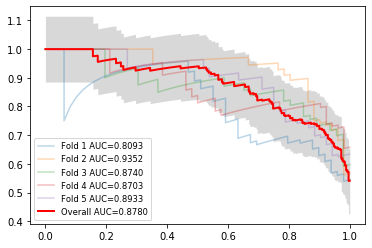

In [6]:
# https://stackoverflow.com/questions/55541254/precision-recall-curve-with-n-fold-cross-validation-showing-standard-deviation

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from numpy import interp
from sklearn.metrics import auc

X, y = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=10.0,
    random_state=10)

k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
predictor = SVC(kernel='linear', C=1.0, probability=True, random_state=10)

y_real = []
y_proba = []

precision_array = []
threshold_array=[]
recall_array = np.linspace(0, 1, 100)

for i, (train_index, test_index) in enumerate(k_fold.split(X)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision_fold, recall_fold, thresh = precision_recall_curve(ytest, pred_proba[:,1])
    precision_fold, recall_fold, thresh = precision_fold[::-1], recall_fold[::-1], thresh[::-1]  # reverse order of results
    thresh = np.insert(thresh, 0, 1.0)
    precision_array = interp(recall_array, recall_fold, precision_fold)
    threshold_array = interp(recall_array, recall_fold, thresh)
    pr_auc = auc(recall_array, precision_array)

    lab_fold = 'Fold %d AUC=%.4f' % (i+1, pr_auc)
    plt.plot(recall_fold, precision_fold, alpha=0.3, label=lab_fold)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))

plt.plot(recall, precision, lw=2,color='red', label=lab)

plt.legend(loc='lower left', fontsize='small')

mean_precision = np.mean(precision_array)
std_precision = np.std(precision_array)
plt.fill_between(recall, precision + std_precision, precision - std_precision, alpha=0.3, linewidth=0, color='grey')
plt.show()

# Metrics calculation

In [7]:
from sklearn.metrics import roc_auc_score

class MultiClassMetrics():
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        
    def calculate_scores(self, class_mapping_dict=None):
    
        y_true_ = self.y_true
        y_pred_ = self.y_pred
        if classes_map_dict is not None:
            y_true_ = y_true_.map(classes_map_dict)
            y_pred_ = y_pred_.map(classes_map_dict)
    
        self.cnf_matrix = confusion_matrix(y_true_, y_pred_)
        self.FP = self.cnf_matrix.sum(axis=0) - np.diag(self.cnf_matrix) 
        self.FN = self.cnf_matrix.sum(axis=1) - np.diag(self.cnf_matrix)
        self.TP = np.diag(self.cnf_matrix)
        self.TN = self.cnf_matrix.sum() - (self.FP + self.FN + self.TP)
        self.FP = self.FP.astype(float)
        self.FN = self.FN.astype(float)
        self.TP = self.TP.astype(float)
        self.TN = self.TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate
        self.TPR = self.TP/(self.TP+self.FN)
        # Specificity or true negative rate
        self.TNR = self.TN/(self.TN+self.FP) 
        # Precision or positive predictive value
        self.PPV = self.TP/(self.TP+self.FP)
        # Negative predictive value
        self.NPV = self.TN/(self.TN+self.FN)
        # Fall out or false positive rate
        self.FPR = self.FP/(self.FP+self.TN)
        # False negative rate
        self.FNR = self.FN/(self.TP+self.FN)
        # False discovery rate
        self.FDR = self.FP/(self.TP+self.FP)
        # Overall accuracy for each class
        self.ACC = (self.TP+self.TN)/(self.TP+self.FP+self.FN+self.TN)

        self.F1_micro = f1_score(y_true_, y_pred_, average='micro')
        self.F1_macro = f1_score(y_true_, y_pred_, average='macro')
        self.F1_weighted = f1_score(y_true_, y_pred_, average='weighted')
        
#         self.AUC = auc(y_true_, y_pred_)

class MultiClassFoldsMetrics():
    def __init__(self, multi_class_metrics_list):
        self.multi_class_metrics_list = multi_class_metrics_list
        
    def calc_scores(self, class_mapping_dict=None, classes_n=None):
#         classes_n = self.multi_class_metrics_list[0].y_true.unique().shape[0]
        folds_n = len(self.multi_class_metrics_list)
        
        self.classes_n = classes_n
        self.folds_n = folds_n
        
        self.TPR_arr = np.zeros((folds_n, classes_n))
        self.TNR_arr = np.zeros((folds_n, classes_n))
        self.PPV_arr = np.zeros((folds_n, classes_n))
        self.NPV_arr = np.zeros((folds_n, classes_n))
        self.FPR_arr = np.zeros((folds_n, classes_n))
        self.FNR_arr = np.zeros((folds_n, classes_n))
        self.FDR_arr = np.zeros((folds_n, classes_n))
        self.ACC_arr = np.zeros((folds_n, classes_n))
        self.F1_micro_arr = np.zeros((folds_n))
        self.F1_macro_arr = np.zeros((folds_n))
        self.F1_weighted_arr = np.zeros((folds_n))
        self.cnf_matrix_arr = np.zeros((classes_n, classes_n))
#         self.AUC_arr = np.zeros((folds_n, classes_n))
        
        fold_n = 0
        for m in self.multi_class_metrics_list:
            m.calculate_scores(class_mapping_dict)

            self.TPR_arr[fold_n,:]=m.TPR
            self.TNR_arr[fold_n,:]=m.TNR
            self.PPV_arr[fold_n,:]=m.PPV
            self.NPV_arr[fold_n,:]=m.NPV
            self.FPR_arr[fold_n,:]=m.FPR
            self.FNR_arr[fold_n,:]=m.FNR
            self.FDR_arr[fold_n,:]=m.FDR
            self.ACC_arr[fold_n,:]=m.ACC
            self.F1_micro_arr[fold_n]=m.F1_micro
            self.F1_macro_arr[fold_n]=m.F1_macro
            self.F1_weighted_arr[fold_n]=m.F1_weighted
            self.cnf_matrix_arr = np.add(self.cnf_matrix_arr, m.cnf_matrix)
            
#             self.AUC_arr = m.AUC
            
            fold_n = fold_n + 1
            
    def print_scores(self):
        print('TPR={}, TNR={}, PPV={}, NPV={}, FPR={}, FNR={}, FDR={}, ACC={}, F1_micro={}, F1_macro={}, F1_weighted={}'.format(  #, AUC={}
                self.TPR_arr.mean(axis=0), 
                self.TNR_arr.mean(axis=0), 
                self.PPV_arr.mean(axis=0), 
                self.NPV_arr.mean(axis=0), 
                self.FPR_arr.mean(axis=0), 
                self.FNR_arr.mean(axis=0), 
                self.FDR_arr.mean(axis=0), 
                self.ACC_arr.mean(axis=0), 
                self.F1_micro_arr.mean(), 
                self.F1_macro_arr.mean(), 
                self.F1_weighted_arr.mean()  #,
#                 self.AUC_arr.mean(axis=0) 
                )
             )
        print('{}'.format(self.cnf_matrix_arr))
        
    def print_mean_classification_report(self, classes_map_dict=None, target_names=None):
        y_true_, y_pred_ = self.collect_ys(classes_map_dict)
        print(classification_report(y_true_, y_pred_, target_names=target_names))
        
    def collect_ys(self, classes_map_dict=None):
        y_true_ = pd.Series()
        y_pred_ = pd.Series()
        for m in self.multi_class_metrics_list:
            __y_tr = m.y_true.copy()
            __y_pr = m.y_pred.copy()
            
            if classes_map_dict is not None:
                __y_tr = __y_tr.map(classes_map_dict)
                __y_pr = __y_pr.map(classes_map_dict)
                
            y_true_ = y_true_.append(__y_tr, ignore_index=True, verify_integrity=False)
            y_pred_ = y_pred_.append(__y_pr, ignore_index=True, verify_integrity=False)
            
        return y_true_, y_pred_
        


In [16]:
def build_multi_class_metrics_list(val_file_template, layer, set_id, folds_n, classes_n):
    
    multi_class_metrics_list = []
    for fold_n in range(folds_n):
        file_path=val_file_template.format(layer, set_id, fold_n)
        df = pd.read_csv(file_path)
        
        true_value = df['true_value']
        pred_value = df['pred_value']
        
        multi_class_metric = MultiClassMetrics(true_value, pred_value)
        multi_class_metrics_list.append(multi_class_metric)
        
    return MultiClassFoldsMetrics(multi_class_metrics_list)

In [15]:
# val_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation4_logits_predictions.csv"
# train_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train4_logits_predictions.csv"
val_file_template="/mnt/models/darts_retrained/7ch_128x128_no_metainfo_registered_5Fold_newC43_27Nov2020-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation7ch_logits_predictions.csv"
train_file_template=     "/mnt/models/darts_retrained/7ch_128x128_no_metainfo_registered_5Fold_newC43_27Nov2020-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train7ch_logits_predictions.csv"



# ClassSet1

In [17]:
layers = [1,2,3,4,5]
sets = [1]

folds_n = 5
classes_n = 2

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = validation_file_path.format()
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign'])
      
        
        print('--------------------------------')
        
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign'])
        
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-1
Validation:
TPR=[0.73058275 0.96537738], TNR=[0.96537738 0.73058275], PPV=[0.78027473 0.95677986], NPV=[0.95677986 0.78027473], FPR=[0.03462262 0.26941725], FNR=[0.26941725 0.03462262], FDR=[0.21972527 0.04322014], ACC=[0.9321897 0.9321897], F1_micro=0.9321897046318879, F1_macro=0.8527596719403091, F1_weighted=0.930598099665984
[[ 48.  18.]
 [ 14. 391.]]
                       precision    recall  f1-score   support

Melanoma_like_lesions       0.77      0.73      0.75        66
     Pigmented_benign       0.96      0.97      0.96       405

             accuracy                           0.93       471
            macro avg       0.87      0.85      0.86       471
         weighted avg       0.93      0.93      0.93       471

--------------------------------
Training:
TPR=[0.95840216 0.99444993], TNR=[0.99444993 0.95840216], PPV=[0.96618278 0.99325713], NPV=[0.99325713 0.96618278], FPR=[0.00555007 0.04159784], FNR=[0.04159784 0.00555007], FDR=[0.03381722 0.00674287], 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.99622642 0.99876352], TNR=[0.99876352 0.99622642], PPV=[0.99252271 0.99938838], NPV=[0.99938838 0.99252271], FPR=[0.00123648 0.00377358], FNR=[0.00377358 0.00123648], FDR=[0.00747729 0.00061162], ACC=[0.99840846 0.99840846], F1_micro=0.9984084582023985, F1_macro=0.9966979210340716, F1_weighted=0.9984105446497631
[[2.630e+02 1.000e+00]
 [2.000e+00 1.618e+03]]
                       precision    recall  f1-score   support

Melanoma_like_lesions       0.99      1.00      0.99       264
     Pigmented_benign       1.00      1.00      1.00      1620

             accuracy                           1.00      1884
            macro avg       1.00      1.00      1.00      1884
         weighted avg       1.00      1.00      1.00      1884

--------------------------------
--------------------------------
Layers-3, Set-1
Validation:
TPR=[0.78218448 0.96035092], TNR=[0.96035092 0.78218448], PPV=[0.77172592 0.96392027], NPV=[0.96392027 0.77172592], FPR=[0.03964908 0.21781552], FNR=[0.21781

### 4 - layers is the best (looking at TPR for MLL class) 

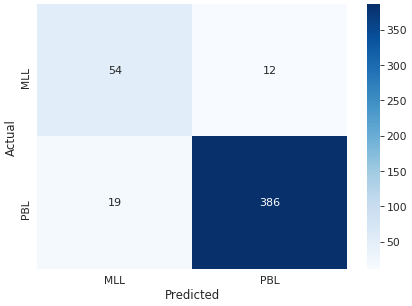

In [20]:
data = np.array([[ 54.,  12.],
                 [ 19., 386.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL'], index = ['MLL', 'PBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size

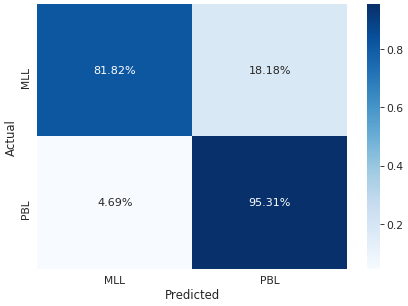

In [21]:
data = np.array([[ 54.,  12.],
                 [ 19., 386.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL'], index = ['MLL', 'PBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size

# ClassSet3

In [22]:
layers = [1,2,3,4,5]
sets = [3]

folds_n = 5
classes_n = 4

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1}
#         classes_map_dict={0:1, 1:0, 2:0, 3:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0}
#         classes_map_dict={0:1, 1:0, 2:0, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])        
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-3
Validation:
TPR=[0.6241958  0.84406021 0.56082178 0.56776589], TNR=[0.9793936  0.75042972 0.89830852 0.90624715], PPV=[0.72421272 0.74157755 0.68685201 0.59296812], NPV=[0.9701879  0.85290868 0.84187066 0.89879933], FPR=[0.0206064  0.24957028 0.10169148 0.09375285], FNR=[0.3758042  0.15593979 0.43917822 0.43223411], FDR=[0.27578728 0.25842245 0.31314799 0.40703188], ACC=[0.9529542  0.79277374 0.80431351 0.84131872], F1_micro=0.6956800864636415, F1_macro=0.6596703186410621, F1_weighted=0.6892985188546412
[[ 41.  12.   2.  11.]
 [  6. 342.  34.  23.]
 [  2.  74. 139.  33.]
 [  9.  36.  29.  97.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.71      0.62      0.66        66
       Pigmented_benign       0.74      0.84      0.79       405
        Keratin_lesions       0.68      0.56      0.62       248
Nonmelanoma_skin_cancer       0.59      0.57      0.58       171

               accuracy                           0.70 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.87880995 0.97468322 0.84642126 0.87554098], TNR=[0.99514595 0.9131921  0.97740635 0.97632292], PPV=[0.93631151 0.90397596 0.93530589 0.89894616], NPV=[0.99034456 0.97742165 0.94290798 0.97062437], FPR=[0.00485405 0.0868079  0.02259365 0.02367708], FNR=[0.12119005 0.02531678 0.15357874 0.12445902], FDR=[0.06368849 0.09602404 0.06469411 0.10105384], ACC=[0.98652158 0.94120171 0.94094513 0.95693952], F1_micro=0.9128039686742093, F1_macro=0.9048093047316476, F1_weighted=0.9119149599265624
[[ 232.   18.    2.   12.]
 [   5. 1579.   20.   16.]
 [   2.  110.  840.   40.]
 [   9.   40.   36.  599.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.94      0.88      0.91       264
       Pigmented_benign       0.90      0.97      0.94      1620
        Keratin_lesions       0.94      0.85      0.89       992
Nonmelanoma_skin_cancer       0.90      0.88      0.89       684

               accuracy                           0.91      3560
  

TPR=[0.99230485 0.99384985 0.98789158 0.98094597], TNR=[0.99608148 0.99326749 0.99725851 0.99861705], PPV=[0.95518286 0.99206136 0.99288141 0.99410628], NPV=[0.99938928 0.99494495 0.99534458 0.99548511], FPR=[0.00391852 0.00673251 0.00274149 0.00138295], FNR=[0.00769515 0.00615015 0.01210842 0.01905403], FDR=[0.04481714 0.00793864 0.00711859 0.00589372], ACC=[0.99580738 0.99355053 0.99464611 0.99521989], F1_micro=0.9896119544540255, F1_macro=0.98588112553094, F1_weighted=0.9896598028082361
[[2.62e+02 1.00e+00 1.00e+00 0.00e+00]
 [6.00e+00 1.61e+03 2.00e+00 2.00e+00]
 [3.00e+00 7.00e+00 9.80e+02 2.00e+00]
 [4.00e+00 5.00e+00 4.00e+00 6.71e+02]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.95      0.99      0.97       264
       Pigmented_benign       0.99      0.99      0.99      1620
        Keratin_lesions       0.99      0.99      0.99       992
Nonmelanoma_skin_cancer       0.99      0.98      0.99       684

               accura

TPR=[0.98845869 0.99569604 0.98894616 0.98244861], TNR=[0.99606295 0.99279578 0.99805123 0.99965753], PPV=[0.95448221 0.99142397 0.99493716 0.99852941], NPV=[0.99908344 0.9964176  0.99573381 0.99584538], FPR=[0.00393705 0.00720422 0.00194877 0.00034247], FNR=[0.01154131 0.00430396 0.01105384 0.01755139], FDR=[0.04551779 0.00857603 0.00506284 0.00147059], ACC=[0.99550547 0.99411765 0.99550931 0.99635216], F1_micro=0.9907422970865978, F1_macro=0.9866203466087381, F1_weighted=0.9908029826758069
[[2.610e+02 2.000e+00 1.000e+00 0.000e+00]
 [4.000e+00 1.613e+03 2.000e+00 1.000e+00]
 [3.000e+00 8.000e+00 9.810e+02 0.000e+00]
 [6.000e+00 4.000e+00 2.000e+00 6.720e+02]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.95      0.99      0.97       264
       Pigmented_benign       0.99      1.00      0.99      1620
        Keratin_lesions       0.99      0.99      0.99       992
Nonmelanoma_skin_cancer       1.00      0.98      0.99       684

   

### 5 - layers give best TPR for MLL class

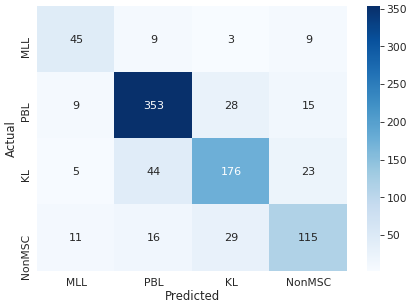

In [23]:
data = np.array([[ 45.,   9.,   3.,   9.],
                 [  9., 353.,  28.,  15.],
                 [  5.,  44., 176.,  23.],
                 [ 11.,  16.,  29., 115.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC'], index = ['MLL', 'PBL', 'KL', 'NonMSC'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size

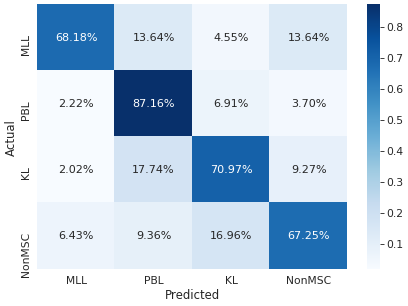

In [24]:
data = np.array([[ 45.,   9.,   3.,   9.],
                 [  9., 353.,  28.,  15.],
                 [  5.,  44., 176.,  23.],
                 [ 11.,  16.,  29., 115.]])

if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC'], index = ['MLL', 'PBL', 'KL', 'NonMSC'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size

# ClassSet4

In [25]:
layers = [1,2,3,4,5]
sets = [4]

folds_n = 5
classes_n = 2

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['C43', 'D22'])
          
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['C43', 'D22'])
              
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-4
Validation:
TPR=[0.77870463 0.9797444 ], TNR=[0.9797444  0.77870463], PPV=[0.86926407 0.96543454], NPV=[0.96543454 0.86926407], FPR=[0.0202556  0.22129537], FNR=[0.22129537 0.0202556 ], FDR=[0.13073593 0.03456546], ACC=[0.95196723 0.95196723], F1_micro=0.9519672266464146, F1_macro=0.8931273671583106, F1_weighted=0.950636719817261
[[ 48.  14.]
 [  8. 386.]]
              precision    recall  f1-score   support

         C43       0.86      0.77      0.81        62
         D22       0.96      0.98      0.97       394

    accuracy                           0.95       456
   macro avg       0.91      0.88      0.89       456
weighted avg       0.95      0.95      0.95       456

--------------------------------
--------------------------------
--------------------------------
Training:
TPR=[1.         0.99809725], TNR=[0.99809725 1.        ], PPV=[0.98815686 1.        ], NPV=[1.         0.98815686], FPR=[0.00190275 0.        ], FNR=[0.         0.00190275], FDR=[0.01184314

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.99191837 0.99936508], TNR=[0.99936508 0.99191837], PPV=[0.99607843 0.99873617], NPV=[0.99873617 0.99607843], FPR=[0.00063492 0.00808163], FNR=[0.00808163 0.00063492], FDR=[0.00392157 0.00126383], ACC=[0.99835616 0.99835616], F1_micro=0.9983561561576384, F1_macro=0.9964934331445381, F1_weighted=0.9983537081453315
[[2.460e+02 2.000e+00]
 [1.000e+00 1.575e+03]]
              precision    recall  f1-score   support

         C43       1.00      0.99      0.99       248
         D22       1.00      1.00      1.00      1576

    accuracy                           1.00      1824
   macro avg       1.00      1.00      1.00      1824
weighted avg       1.00      1.00      1.00      1824

--------------------------------
--------------------------------
Layers-3, Set-4
Validation:
TPR=[0.7990343  0.96958536], TNR=[0.96958536 0.7990343 ], PPV=[0.80506605 0.96790672], NPV=[0.96790672 0.80506605], FPR=[0.03041464 0.2009657 ], FNR=[0.2009657  0.03041464], FDR=[0.19493395 0.03209328], ACC=[0.9

### 4- layers give best TPR for MLL class

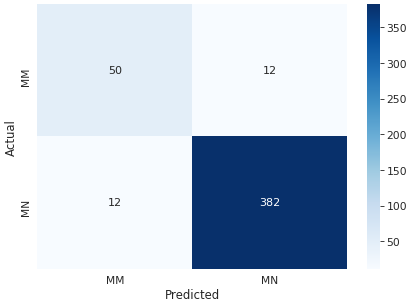

In [26]:
data = np.array([[ 50.,  12.],
                 [ 12., 382.]])

if False: 
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
# df_cm = pd.DataFrame(data, columns=['C43', 'D22'], index = ['C43', 'D22'])
df_cm = pd.DataFrame(data, columns=['MM', 'MN'], index = ['MM', 'MN'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size

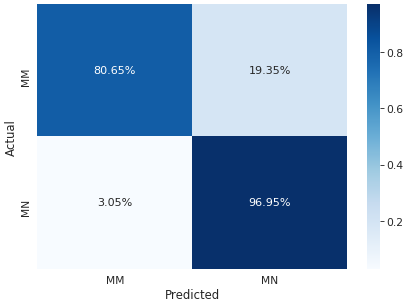

In [27]:
data = np.array([[ 50.,  12.],
                 [ 12., 382.]])

if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]

# df_cm = pd.DataFrame(data, columns=['C43', 'D22'], index = ['C43', 'D22'])
df_cm = pd.DataFrame(data, columns=['MM', 'MN'], index = ['MM', 'MN'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size

# ClassSet8

In [28]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
TPR=[0.61086247 0.73571273 0.460979   0.4385918  0.78060411], TNR=[0.98279441 0.88544378 0.96370073 0.9575097  0.72614298], PPV=[0.6697619  0.7236778  0.73258041 0.59067562 0.61974718], NPV=[0.98073818 0.89163762 0.89264522 0.92436974 0.85278698], FPR=[0.01720559 0.11455622 0.03629927 0.0424903  0.27385702], FNR=[0.38913753 0.26428727 0.539021   0.5614082  0.21939589], FDR=[0.3302381  0.2763222  0.26741959 0.40932438 0.38025282], ACC=[0.96512728 0.84205581 0.87455528 0.89392609 0.7459546 ], F1_micro=0.6608095320355114, F1_macro=0.621386640323864, F1_weighted=0.6526977216471708
[[ 40.  10.   0.   5.  11.]
 [  9. 298.  10.   8.  80.]
 [  2.  39. 114.  12.  81.]
 [  9.   9.   6.  75.  72.]
 [  3.  56.  26.  27. 396.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.63      0.61      0.62        66
       Pigmented_benign       0.72      0.74      0.73       405
        Keratin_lesions       0.73      0.46      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.77235077 0.89500118 0.67551837 0.71918968 0.93155737], TNR=[0.99286471 0.9501058  0.99369656 0.98552758 0.84642718], PPV=[0.8433536  0.88014048 0.95894335 0.87453872 0.77656578], NPV=[0.98878004 0.9568786  0.93441349 0.96182915 0.95620243], FPR=[0.00713529 0.0498942  0.00630344 0.01447242 0.15357282], FNR=[0.22764923 0.10499882 0.32448163 0.28081032 0.06844263], FDR=[0.1566464  0.11985952 0.04105665 0.12546128 0.22343422], ACC=[0.98246204 0.93413779 0.9373185  0.95293624 0.87736098], F1_micro=0.8421077719940027, F1_macro=0.8238564226586653, F1_weighted=0.8396017636595872
[[ 204.   17.    0.   10.   33.]
 [  18. 1450.   13.   11.  128.]
 [   2.   73.  671.   28.  218.]
 [  14.    7.    4.  492.  167.]
 [   4.  101.   12.   22. 1893.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.84      0.77      0.81       264
       Pigmented_benign       0.88      0.90      0.89      1620
        Keratin_lesions       0.96      0.68      0.7

TPR=[0.96405377 0.99268945], TNR=[0.99268945 0.96405377], PPV=[0.96428253 0.9926701 ], NPV=[0.9926701  0.96428253], FPR=[0.00731055 0.03594623], FNR=[0.03594623 0.00731055], FDR=[0.03571747 0.0073299 ], ACC=[0.98783402 0.98783402], F1_micro=0.9878340202740773, F1_macro=0.978381973411319, F1_weighted=0.9878296682248289
[[ 914.   34.]
 [  34. 4610.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.96      0.96      0.96       948
 PB+KL+Other       0.99      0.99      0.99      4644

    accuracy                           0.99      5592
   macro avg       0.98      0.98      0.98      5592
weighted avg       0.99      0.99      0.99      5592

--------------------------------
--------------------------------
Layers-3, Set-8
Validation:
TPR=[0.65386613 0.78511791 0.58942102 0.5493167  0.768828  ], TNR=[0.98053605 0.88989371 0.93428229 0.96979176 0.82189849], PPV=[0.64440846 0.74598632 0.65820527 0.72541063 0.71574515], NPV=[0.98281306 0.91052759 0.91386722 0.93

TPR=[0.67300033 0.97689009], TNR=[0.97689009 0.67300033], PPV=[0.6        0.98358672], NPV=[0.98358672 0.6       ], FPR=[0.02310991 0.32699967], FNR=[0.32699967 0.02310991], FDR=[0.4        0.01641328], ACC=[0.96241231 0.96241231], F1_micro=0.9624123138951411, F1_macro=0.8042649177337993, F1_weighted=0.9634979001657985
[[  44.   22.]
 [  31. 1301.]]
                    precision    recall  f1-score   support

               MLL       0.59      0.67      0.62        66
PB+KL+NonMSC+Other       0.98      0.98      0.98      1332

          accuracy                           0.96      1398
         macro avg       0.79      0.82      0.80      1398
      weighted avg       0.96      0.96      0.96      1398

--------------------------------
Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:
TPR=[0.66826289 0.94353684], TNR=[0.94353684 0.66826289], PPV=[0.70985678 0.93313115], NPV=[0.93313115 0.70985678], FPR=[0.05646316 0.33173711], FNR=[0.3317

              precision    recall  f1-score   support

  MLL+NonMSC       0.98      0.94      0.96       948
 PB+KL+Other       0.99      1.00      0.99      4644

    accuracy                           0.99      5592
   macro avg       0.98      0.97      0.97      5592
weighted avg       0.99      0.99      0.99      5592

--------------------------------
--------------------------------


### 4 - layers have best TPR for clas MLL

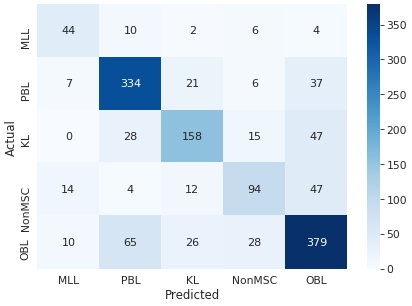

In [29]:
data = np.array([[ 44.,  10.,   2.,   6.,   4.],
                 [  7., 334.,  21.,   6.,  37.],
                 [  0.,  28., 158.,  15.,  47.],
                 [ 14.,   4.,  12.,  94.,  47.],
                 [ 10.,  65.,  26.,  28., 379.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

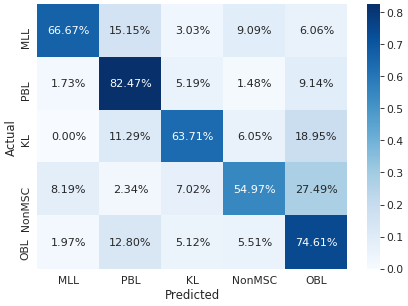

In [30]:
data = np.array([[ 44.,  10.,   2.,   6.,   4.],
                 [  7., 334.,  21.,   6.,  37.],
                 [  0.,  28., 158.,  15.,  47.],
                 [ 14.,   4.,  12.,  94.,  47.],
                 [ 10.,  65.,  26.,  28., 379.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

## ClassSet8 - NonMSC vs rest

In [32]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
#         multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
    
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
        
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.9575097 0.4385918], TNR=[0.4385918 0.9575097], PPV=[0.92436974 0.59067562], NPV=[0.59067562 0.92436974], FPR=[0.5614082 0.0424903], FNR=[0.0424903 0.5614082], FDR=[0.07563026 0.40932438], ACC=[0.89392609 0.89392609], F1_micro=0.8939260911320994, F1_macro=0.7212722030428799, F1_weighted=0.886851847753708
[[1175.   52.]
 [  96.   75.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.92      0.96      0.94      1227
         NonMSC       0.59      0.44      0.50       171

       accuracy                           0.89      1398
      macro avg       0.76      0.70      0.72      1398
   weighted avg       0.88      0.89      0.89      1398

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.98552758 0.71918968], TNR=[0.71918968 0.98552758

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.94607961 0.56729055], TNR=[0.56729055 0.94607961], PPV=[0.9401501  0.61122114], NPV=[0.61122114 0.9401501 ], FPR=[0.43270945 0.05392039], FNR=[0.05392039 0.43270945], FDR=[0.0598499  0.38877886], ACC=[0.89964712 0.89964712], F1_micro=0.8996471193714253, F1_macro=0.7619295170839698, F1_weighted=0.8985738169394046
[[1161.   66.]
 [  74.   97.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.94      0.95      0.94      1227
         NonMSC       0.60      0.57      0.58       171

       accuracy                           0.90      1398
      macro avg       0.77      0.76      0.76      1398
   weighted avg       0.90      0.90      0.90      1398

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.99348658 0.95453789], TNR=[0.95453789 0.99348658], PPV=[0.99367015 

### 2 layers seems the best (based on TPR for NonMSC class (MLL+PB+KL+Other is good))

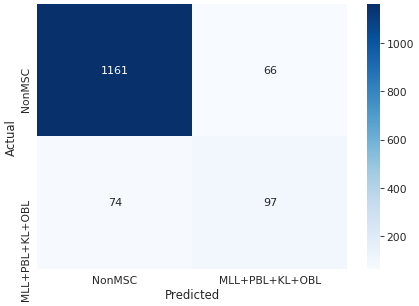

In [33]:
data = np.array([[1161.,  66.],
                 [ 74.,  97.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')# font size .2%

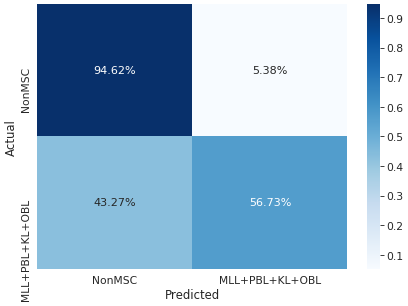

In [34]:
data = np.array([[1161.,  66.],
                 [ 74.,  97.]])

if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='.2%')# font size .2%

# Playground

In [191]:


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [202]:
# plot_confusion_matrix(cm           = np.array([[ 32.,   7.,   1.,   5.,   2.],
#                                              [  5., 327.,  25.,   8.,  42.],
#                                              [  1.,  32., 161.,  13.,  41.],
#                                              [  7.,   4.,  17., 100.,  43.],
#                                              [  7.,  63.,  28.,  35., 375.]]), 
#                       normalize    = False,
#                       target_names = ['MLL', 'PBL', 'KL', 'NonMSC', 'Other'],
#                       title        = "Confusion Matrix")

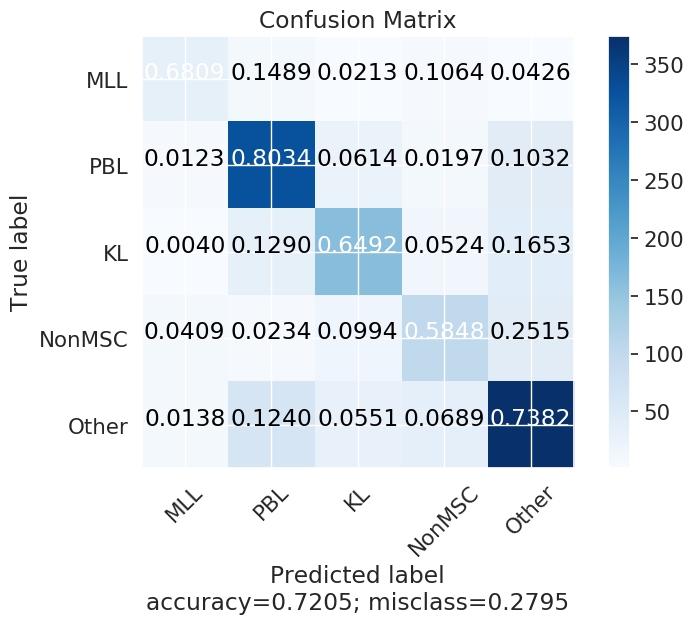

In [193]:
# fig = plt.figure(figsize=(6, 6), dpi=300)
plot_confusion_matrix(cm           = np.array([[ 32.,   7.,   1.,   5.,   2.],
                                             [  5., 327.,  25.,   8.,  42.],
                                             [  1.,  32., 161.,  13.,  41.],
                                             [  7.,   4.,  17., 100.,  43.],
                                             [  7.,  63.,  28.,  35., 375.]]), 
                      normalize    = True,
                      target_names = ['MLL', 'PBL', 'KL', 'NonMSC', 'Other'],
                      title        = "Confusion Matrix")